In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_dataset = datasets.MNIST(
    root="data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="data",
    train=False,
    transform=transform,
    download=True
)

In [4]:
len(train_dataset)

60000

In [5]:
len(test_dataset)

10000

In [6]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False
)

data_iter = iter(train_loader)
images, labels = next(data_iter)

In [8]:
labels[0]

tensor(4)

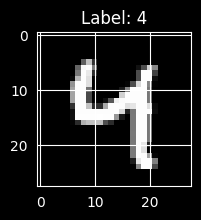

In [7]:
plt.figure(figsize=(2,2))
plt.imshow(images[0].numpy().squeeze(), cmap='gray')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [9]:
class DigitsClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )
    def forward(self, x):
        return self.network(x)

In [10]:
model = DigitsClassifier()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [12]:
epochs = 5

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.2f}")

Epoch [1/5], Loss: 0.08
Epoch [2/5], Loss: 0.07
Epoch [3/5], Loss: 0.06
Epoch [4/5], Loss: 0.06
Epoch [5/5], Loss: 0.06


In [18]:
model.eval()

total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 97.22%


In [19]:
total, correct

(10000, 9722)

In [20]:
model.eval()

all_predicted = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.numpy())
        all_predicted.extend(predicted.numpy())

In [21]:
len(all_predicted)

10000

In [22]:
from sklearn.metrics import classification_report

report = classification_report(all_labels, all_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.99      0.97      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.98      0.97      1028
           8       0.94      0.98      0.96       974
           9       0.98      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predicted)
cm

array([[ 970,    0,    0,    1,    0,    1,    5,    1,    0,    2],
       [   0, 1120,    1,    3,    0,    0,    2,    1,    8,    0],
       [  10,    1,  991,    6,    5,    1,    3,    6,    9,    0],
       [   2,    0,    1,  996,    0,    3,    0,    3,    4,    1],
       [   1,    0,    3,    1,  957,    1,    2,    4,    1,   12],
       [   4,    1,    0,   10,    3,  857,   10,    1,    5,    1],
       [   5,    3,    1,    0,    3,    3,  940,    0,    3,    0],
       [   3,    2,    9,    5,    0,    0,    1, 1003,    3,    2],
       [   7,    0,    1,    3,    1,    4,    2,    3,  953,    0],
       [   5,    2,    0,   16,    9,    5,    0,   14,   23,  935]])

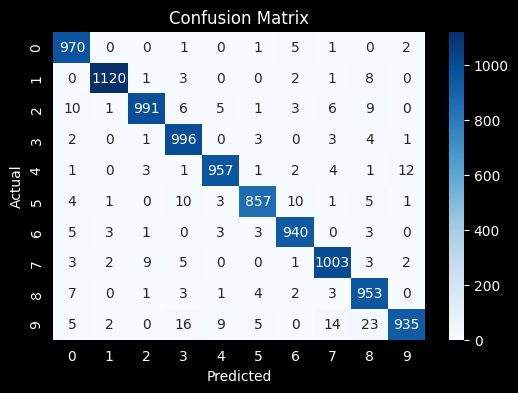

In [24]:
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(cm)), yticklabels=range(len(cm[0])))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()